## Final Model - Random Forest

### Data

In [32]:

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
import imblearn.over_sampling
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve

In [11]:
path = 'data/archive (2)/'
df_train = pd.read_csv(path+'train.csv')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Term                          67463 non-null  int64  
 5   Batch Enrolled                67463 non-null  object 
 6   Interest Rate                 67463 non-null  float64
 7   Grade                         67463 non-null  object 
 8   Sub Grade                     67463 non-null  object 
 9   Employment Duration           67463 non-null  object 
 10  Home Ownership                67463 non-null  float64
 11  Verification Status           67463 non-null  object 
 12  Payment Plan                  67463 non-null  object 
 13  L

In [12]:
df_new = df_train.drop(['Collection 12 months Medical','Accounts Delinquent','Term','Batch Enrolled','Sub Grade','Payment Plan',\
              'Initial List Status','Application Type','Recoveries','Revolving Balance','Loan Title'],axis=1)
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67463 entries, 0 to 67462
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            67463 non-null  int64  
 1   Loan Amount                   67463 non-null  int64  
 2   Funded Amount                 67463 non-null  int64  
 3   Funded Amount Investor        67463 non-null  float64
 4   Interest Rate                 67463 non-null  float64
 5   Grade                         67463 non-null  object 
 6   Employment Duration           67463 non-null  object 
 7   Home Ownership                67463 non-null  float64
 8   Verification Status           67463 non-null  object 
 9   Debit to Income               67463 non-null  float64
 10  Delinquency - two years       67463 non-null  int64  
 11  Inquires - six months         67463 non-null  int64  
 12  Open Account                  67463 non-null  int64  
 13  P

In [13]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    
    total_users = df['ID'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['ID'].isin(test_users)]
    df_te = df[df['ID'].isin(test_users)] 

    y_tr, y_te = df_tr['Loan Status'], df_te['Loan Status']
    X_tr = df_tr.drop(['ID','Loan Status'],axis=1)
    X_te = df_te.drop(['ID','Loan Status'],axis=1)

    return X_tr, X_te, y_tr, y_te

In [14]:

The_X = pd.get_dummies(df_new.drop(['Loan Status'],axis=1),drop_first=True)
#The_X = df_train[['ID','Debit to Income','Public Record','Total Accounts','Total Current Balance']]
The_X['Loan Status'] = df_new[['Loan Status']]

In [15]:
XX = The_X.drop(['Inquires - six months','Verification Status_Source Verified','Employment Duration_RENT',\
                       'Verification Status_Verified','Grade_C','Grade_B','Grade_D','Grade_E','Grade_F','Grade_G','Public Record',\
                       'Employment Duration_OWN'],axis = 1)
y = df_train[['Loan Status']]
X_tr_x, X_te_o, y_tr, y_te = get_user_split_data(XX)
from sklearn.model_selection import train_test_split
#Split data into 3: 60% train, 20% validation, 20% test
X_tr_o, X_val_o, y_tr, y_val = train_test_split(X_tr_x, y_tr, test_size=0.25, random_state=2019)


In [16]:

scaler = StandardScaler()

In [17]:
X_tr = pd.DataFrame(scaler.fit_transform(X_tr_o),columns = X_tr_o.columns)
X_te = pd.DataFrame(scaler.fit_transform(X_te_o),columns = X_te_o.columns)
X_val = pd.DataFrame(scaler.fit_transform(X_val_o),columns = X_val_o.columns)

In [61]:
X_tr.head()
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40478 entries, 0 to 40477
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Loan Amount                   40478 non-null  float64
 1   Funded Amount                 40478 non-null  float64
 2   Funded Amount Investor        40478 non-null  float64
 3   Interest Rate                 40478 non-null  float64
 4   Home Ownership                40478 non-null  float64
 5   Debit to Income               40478 non-null  float64
 6   Delinquency - two years       40478 non-null  float64
 7   Open Account                  40478 non-null  float64
 8   Revolving Utilities           40478 non-null  float64
 9   Total Accounts                40478 non-null  float64
 10  Total Received Interest       40478 non-null  float64
 11  Total Received Late Fee       40478 non-null  float64
 12  Collection Recovery Fee       40478 non-null  float64
 13  L

In [19]:
n_pos = np.sum(y_tr == 1)
n_neg = np.sum(y_tr == 0)
ratio = {1 : n_pos * 5, 0 : n_neg} 
smt = imblearn.over_sampling.SMOTE(sampling_strategy = ratio, random_state = 42)
X_tr_smt, y_tr_smt = smt.fit_resample(X_tr,y_tr)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.metrics import balanced_accuracy_score

### Random Forest

In [22]:
ftwo_scorer = make_scorer(fbeta_score, beta=0.75, average='weighted')
accuracy_balanced = make_scorer(balanced_accuracy_score)
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1,5, 50]

# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

scoring = {"Fbeta": ftwo_scorer, "Balanced Accuracy": accuracy_balanced}
# First create the base model to tune
rf = RandomForestClassifier(class_weight='balanced')

rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, scoring = scoring,
                          cv = 3, n_jobs = -1, verbose = 2 , refit="Fbeta", return_train_score=True)
# Fit the random search model
rf_grid.fit(X_tr_smt, y_tr_smt)

results = rf_grid.cv_results_

# View best parameter
print('Best Score: ', rf_grid.best_score_)
print('Best Param: ', rf_grid.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best Score:  0.8940370518743989
Best Param:  {'max_depth': 50, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}


In [23]:
#Random Forest model with the selected params
rf_full = RandomForestClassifier(max_depth = 50, max_features= 'auto',min_samples_leaf = 1, 
                                       min_samples_split= 2, n_estimators=150)
rf_full.fit(X_tr_smt, y_tr_smt)

RandomForestClassifier(max_depth=50, n_estimators=150)

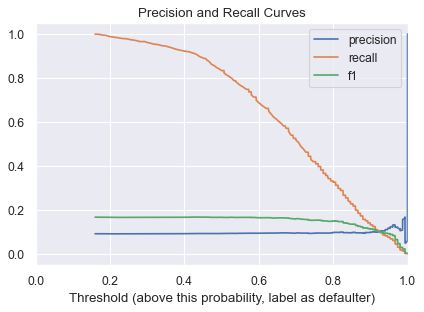

In [28]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_te, rf_full.predict_proba(X_te)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve, 2*(recall_curve[1:]*precision_curve[1:])/(precision_curve[1:]+recall_curve[1:]), label='f1')
plt.legend(loc='upper right')
plt.xlabel('Threshold (above this probability, label as defaulter)');
plt.xlim([0,1]);
plt.title('Precision and Recall Curves');

In [29]:
scoress = cross_val_score(rf_full, X_tr_smt, y_tr_smt, cv=10, scoring='accuracy')
print(scoress)
print('mean accuracy:',scoress.mean())

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  19.0s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  14.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=200; total time=  24.5s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=150; total time=  20.7s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=  25.5s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=5, n_estimators=150; total time=  41.3s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=150; total time=  37.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=  19.4s
[CV] END max_depth=50, max_features=au

[CV] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  19.8s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  14.3s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  14.6s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=100; total time=  12.9s
[CV] END max_depth=10, max_features=auto, min_samples_leaf=50, min_samples_split=2, n_estimators=200; total time=  27.2s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=  38.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=2, n_estimators=100; total time=  21.6s
[CV] END max_depth=50, max_features=auto, min_samples_leaf=5, min_samples_split=5, n_estimators=100; total time=  26.6s
[CV] END max_depth=50, max_features=au

[0.77507215 0.76659452 0.95111833 0.95165945 0.94587768 0.95255277
 0.95363522 0.94786217 0.94587768 0.95128992]
mean accuracy: 0.9141539880129091


In [53]:
thres = 0.93
y_predoss = (rf_full.predict_proba(X_te)[:,1]>=thres)
print('rf_full on SMT Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_te, y_predoss), roc_auc_score(y_te, rf_full.predict_proba(X_te)[:,1])))
print('rf_full on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_te, y_predoss), recall_score(y_te, y_predoss)))


rf_full on SMT Train Data; Test F1: 0.099, Test AUC: 0.515
rf_full on SMT Train Data; PRECISION: 0.104, RECALL: 0.095


Text(89.00000000000007, 0.5, 'actual')

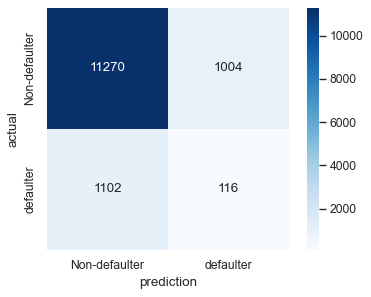

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
y_predict_g = (rf_full.predict_proba(X_te)[:, 1] >= thres)
fraud_confusion = confusion_matrix(y_te, y_predict_g)
plt.figure(dpi=80)
sns.heatmap(fraud_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
       xticklabels=['Non-defaulter', 'defaulter'],
       yticklabels=['Non-defaulter', 'defaulter']);
plt.xlabel('prediction')
plt.ylabel('actual')

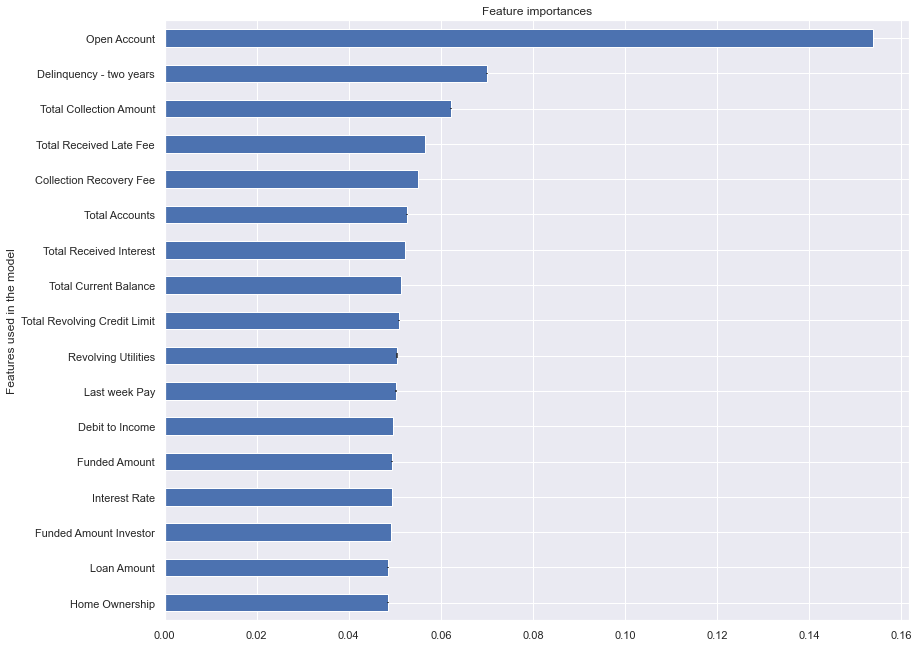

In [49]:
# compute feature importance and std
full_model = X_te.columns.tolist()
# compute feature importance and std
importances = rf_full.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_full.estimators_],
             axis=0)
indices = np.argsort(importances)

feature_list = [full_model[indices[f]] for f in range(X_te.shape[1])]  #names of features.
imp_list = [importances[indices[f]] for f in range(X_te.shape[1])]
ff = np.array(feature_list)

forest_importances = pd.Series(imp_list, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.barh(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Features used in the model")
fig.tight_layout()
fig.set_size_inches(18.5, 10.5)
fig.savefig('feature_importance1.png', dpi=100)


ROC AUC score =  0.5153386361708692


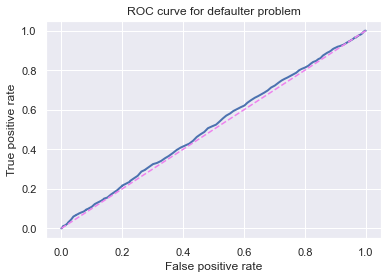

In [50]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
fpr, tpr, thresholds = roc_curve(y_te, rf_full.predict_proba(X_te)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for defaulter problem');
print("ROC AUC score = ", roc_auc_score(y_te, rf_full.predict_proba(X_te)[:,1]))

In [60]:
y_predoss = (rf_full.predict_proba(X_val)[:,1]>=0.9)
print('rf_full on SMT Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(y_val, y_predoss), roc_auc_score(y_val, rf_full.predict_proba(X_val)[:,1])))
print('rf_full on SMT Train Data; PRECISION: %.3f, RECALL: %.3f' % \
      (precision_score(y_val, y_predoss), recall_score(y_val, y_predoss)))


rf_full on SMT Train Data; Test F1: 0.003, Test AUC: 0.512
rf_full on SMT Train Data; PRECISION: 0.105, RECALL: 0.002


In [56]:
y_predoss

array([False, False, False, ..., False, False, False])